#### By: Peyman Shahidi
#### Created: Nov 3, 2025
#### Last Edit: Nov 10, 2025

<br>

In [1]:
#Python
import getpass
import numpy as np
import pandas as pd
from collections import defaultdict
import itertools
import random 

## formatting number to appear comma separated and with two digits after decimal: e.g, 1000 shown as 1,000.00
pd.set_option('float_format', "{:,.2f}".format)

import matplotlib.pyplot as plt
#%matplotlib inline
#from matplotlib.legend import Legend

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 200)

In [2]:
main_folder_path = ".."
input_data_path = f"{main_folder_path}/data"
output_data_path = f'{input_data_path}/computed_objects/ONET_Eloundou_Anthropic_GPT'
output_plot_path = f"{main_folder_path}/writeup/plots/ONET_Eloundou_Anthropic_GPT"

In [3]:
# Create directories if they don't exist
import os

for path in [output_data_path, output_plot_path]:
    if not os.path.exists(path):
        os.makedirs(path)

# Frequent Tasks Analysis or All Tasks Switch

In [4]:
frequent_tasks_analysis = False

# 1) Read O*NET Dataset

In [5]:
# Read O*NET data
ONET = pd.read_csv(f'{input_data_path}/computed_objects/ONET_cleaned_tasks.csv')

# Drop  columns to avoid double counting
# Note: In ~4k instances, the same task is mapped to multiple DWAs
ONET = ONET.drop(columns=['DWA ID', 'DWA Title'])

# Remove duplicate rows
rows_before = len(ONET)
print(f"Number of rows before removing duplicates: {rows_before:,}")
ONET = ONET.drop_duplicates().reset_index(drop=True)
rows_after = len(ONET)
print(f"Number of rows after removing duplicates: {rows_after:,}")
print(f"Duplicates removed: {rows_before - rows_after}")

# Print length of dataset
print(f"Number of rows in ONET dataset: {len(ONET):,}")

Number of rows before removing duplicates: 22,310
Number of rows after removing duplicates: 17,953
Duplicates removed: 4357
Number of rows in ONET dataset: 17,953


# 2) Read and Merge with Eloundou et al.'s AI Exposure Dataset

In [6]:
# Load GPTs are GPTs full label dataset
gpts_full_labels = pd.read_csv(f'{input_data_path}/GPTs-are-GPTs-main/data/full_labelset.tsv', sep="\t")

# Keep relevant columns only
gpts_full_labels = gpts_full_labels[['O*NET-SOC Code', 'Task ID', 'Task', 'Task Type', 'Title', 'gpt4_exposure', 'human_labels']]

# Convert Task ID to integer
gpts_full_labels['Task ID'] = gpts_full_labels['Task ID'].astype(int)

# Remove apostrophes for consistency
gpts_full_labels = gpts_full_labels.applymap(lambda x: x.replace("'", "") if isinstance(x, str) else x)

# Rename columns
gpts_full_labels = gpts_full_labels.rename(columns={
    'Task': 'Task Title',
    'Title': 'Occupation Title'
})

# Print length of dataset
print(f"Number of rows in GPTs full labels dataset: {len(gpts_full_labels):,}")

Number of rows in GPTs full labels dataset: 19,265


In [7]:
# Merge with ONET dataset to get hierarchical codes and titles
ONET = ONET.merge(gpts_full_labels, on=['O*NET-SOC Code', 'Occupation Title', 'Task ID', 'Task Title', 'Task Type'], how='left')

# Check how many tasks were not matched
unmatched_tasks = ONET[ONET['gpt4_exposure'].isna()]
print(f"Number of unmatched tasks: {len(unmatched_tasks):,}")

Number of unmatched tasks: 791


# 3) Read and Merge with Anthropic's AI Use Dataset

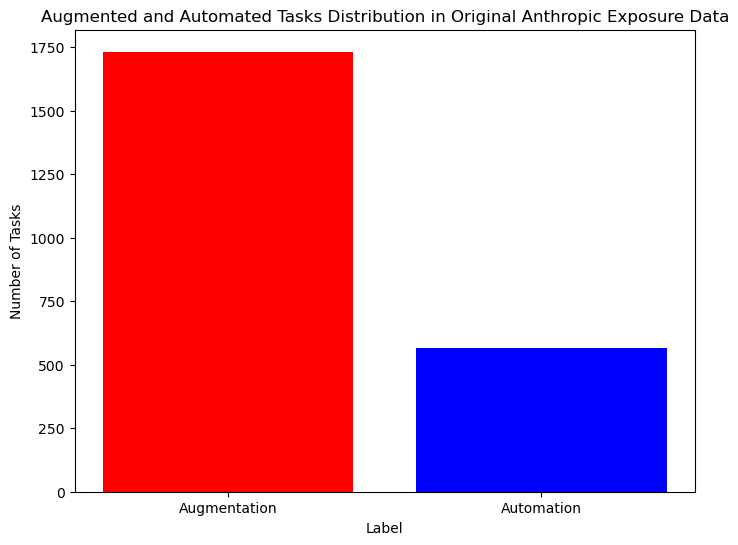

In [8]:
# Merge with Anthropic exposure data
anthropic_exposure = pd.read_csv(f'{input_data_path}/Anthropic_EconomicIndex/automation_vs_augmentation_by_task.csv')

# Remove if all entries are filtered:
anthropic_exposure = anthropic_exposure[anthropic_exposure['filtered'] != 1].reset_index(drop=True)

# Create new columns:
# Sum feedback loop and directive into Automation
# Sum validation, iteration, and learning into Augmentation
anthropic_exposure['automation'] = anthropic_exposure.apply(lambda row: row['feedback_loop'] + row['directive'], axis=1)
anthropic_exposure['augmentation'] = anthropic_exposure.apply(lambda row: row['validation'] + row['task_iteration'] + row['learning'], axis=1)

# Assign labels: take the max of automation, augmentation, manual and assign the corresponding label
def assign_label(row):
    max_value = max(row['automation'], row['augmentation'])
    if max_value == row['automation']:
        return 'Automation'
    elif max_value == row['augmentation']:
        return 'Augmentation'

anthropic_exposure['label'] = anthropic_exposure.apply(assign_label, axis=1)

# Filter to only keep the relevant columns
anthropic_exposure = anthropic_exposure[['task_name', 'automation', 'augmentation', 'label']]

# Plot histogram of the label column to see share of each label
label_counts = anthropic_exposure['label'].value_counts()
plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts.values, color=['red', 'blue'])
plt.title('Augmented and Automated Tasks Distribution in Original Anthropic Exposure Data')
plt.xlabel('Label')
plt.ylabel('Number of Tasks')
plt.savefig(f'{output_plot_path}/anthropicIndex_automatedAugmented_taskDist.png')
plt.show()

In [9]:
# Print number of unique tasks in ONET dataset
print(f"Number of unique tasks in ONET dataset: {ONET['Task Title'].nunique():,}")

# Print number of unique tasks in Anthropic exposure dataset
print(f"Number of unique tasks in Anthropic exposure dataset: {anthropic_exposure['task_name'].nunique():,}")


# Add normalized task title to ONET for merging
ONET["task_normalized"] = ONET["Task Title"].str.lower().str.strip()


# Merge ONET and Anthropic exposure data on the normalized task title
merged_data = pd.merge(ONET, anthropic_exposure[['task_name', 'automation', 'augmentation', 'label']], left_on="task_normalized", right_on="task_name", how="left")

# Fill the NaN values of the label column in merged dataset as Manual
merged_data['label'] = merged_data['label'].fillna('Manual')

# Print distribution after filling NaN values
print(f"\nDistribution of labels after filling NaN values with 'Manual':")
print(merged_data['label'].value_counts())
print(f"Total tasks: {len(merged_data):,}")

# Drop temporary columns used for merging
merged_data = merged_data.drop(columns=['task_normalized', 'task_name'])

Number of unique tasks in ONET dataset: 16,913
Number of unique tasks in Anthropic exposure dataset: 2,298

Distribution of labels after filling NaN values with 'Manual':
label
Manual          15605
Augmentation     1626
Automation        722
Name: count, dtype: int64
Total tasks: 17,953


# 4) Read and Merge with GPT 5-o Mini's Task Sequence Data

In [10]:
if not frequent_tasks_analysis:
    # Read task sequence data
    # Go through computed_objects/tasks_sequences and read all files and merge with original ONET data
    # Get list of files in the directory
    task_sequence_files = [f for f in os.listdir(f'{input_data_path}/computed_objects/tasks_sequences') if f.endswith('.csv')]
    task_sequence = pd.concat([pd.read_csv(f'{input_data_path}/computed_objects/tasks_sequences/{file}') for file in task_sequence_files], ignore_index=True)

    print(f"Task sequence data shape: {task_sequence.shape}")
    print(f"Columns in task sequence: {list(task_sequence.columns)}")

    # Merge task sequence data with merged_data
    merged_data = pd.merge(merged_data, task_sequence[['O*NET-SOC Code', 'Task ID', 'Task Position']], on=['O*NET-SOC Code', 'Task ID'], how='left')
    merged_data = merged_data[merged_data['Task Position'].notna()].reset_index(drop=True)
    merged_data['Task Position'] = pd.to_numeric(merged_data['Task Position'], errors='coerce').astype('Int64')

    # Bring the "Task Position" column next to "Task ID" for better readability
    task_position_col = merged_data.pop('Task Position')
    merged_data.insert(merged_data.columns.get_loc('Task Title') + 1, 'Task Position', task_position_col)

else:
    # Modify output paths for frequent tasks analysis
    output_data_path = f'{input_data_path}/computed_objects/ONET_Eloundou_Anthropic_GPT_frequent'
    os.makedirs(output_data_path, exist_ok=True)
    output_plot_path = f"{main_folder_path}/writeup/plots/ONET_Eloundou_Anthropic_GPT_frequent"
    os.makedirs(output_plot_path, exist_ok=True)
    
    # Read task sequence data for frequent tasks
    # Go through computed_objects/tasks_sequences_frequent and read all files and merge with original ONET data
    # Get list of files in the directory
    task_sequence_files = [f for f in os.listdir(f'{input_data_path}/computed_objects/tasks_sequences_frequent') if f.endswith('.csv')]
    task_sequence = pd.concat([pd.read_csv(f'{input_data_path}/computed_objects/tasks_sequences_frequent/{file}') for file in task_sequence_files], ignore_index=True)

    print(f"Task sequence data shape: {task_sequence.shape}")
    print(f"Columns in task sequence: {list(task_sequence.columns)}")


    # Define frequency importance threshold (in %):
    freq_importance_threshold = 65

    # Filter tasks based on frequency importance threshold
    merged_data['frequent_task'] = merged_data['FT_Daily'] + merged_data['FT_Several times daily'] + merged_data['FT_Hourly or more']
    print(f"Total tasks before filtering: {len(merged_data)}")

    # Length of ONET for different filtering thresholds:
    print("Length of ONET for different frequency importance thresholds:")
    for threshold in [50, 60, 70, 80, 90]:
        filtered_merged_data = merged_data[merged_data['frequent_task'] >= threshold]
        print(f"  - Threshold {threshold}%: {len(filtered_merged_data)} tasks")


    merged_data = merged_data[merged_data['frequent_task'] >= freq_importance_threshold].reset_index(drop=True)
    print(f"Total tasks after filtering infrequent ones: {len(merged_data)}")

    # Remove occupations with three or less frequent tasks
    frequent_tasks_per_occupation_threshold = 3
    occupation_task_counts = merged_data.groupby('O*NET-SOC Code')['Task ID'].nunique()
    valid_occupations = occupation_task_counts[occupation_task_counts >= frequent_tasks_per_occupation_threshold].index
    merged_data = merged_data[merged_data['O*NET-SOC Code'].isin(valid_occupations)].reset_index(drop=True)

    # Merge task sequence data with merged_data
    merged_data = pd.merge(merged_data, task_sequence[['O*NET-SOC Code', 'Task ID', 'Task Position']], on=['O*NET-SOC Code', 'Task ID'], how='left')
    merged_data = merged_data[merged_data['Task Position'].notna()].reset_index(drop=True)
    merged_data['Task Position'] = pd.to_numeric(merged_data['Task Position'], errors='coerce').astype('Int64')

    # Bring the "Task Position" column next to "Task ID" for better readability
    task_position_col = merged_data.pop('Task Position')
    merged_data.insert(merged_data.columns.get_loc('Task Title') + 1, 'Task Position', task_position_col)

Task sequence data shape: (17926, 5)
Columns in task sequence: ['Task Position', 'Task Title', 'Task ID', 'O*NET-SOC Code', 'Occupation Title']


In [11]:
# # Drop the supplemental tasks
# merged_data = merged_data[merged_data['Task Type'] != 'Supplemental'].reset_index(drop=True)

# # Drop rows whose Occupation Title includes 'Teachers, Postsecondary'
# merged_data = merged_data[~merged_data['Occupation Title'].str.contains('Teachers, Postsecondary')].reset_index(drop=True)

In [12]:
# Sort values of merged data before saving
merged_data = merged_data.sort_values(by=['O*NET-SOC Code', 'Task Position'])

# Save merged dataset
os.makedirs(output_data_path, exist_ok=True)
# merged_data.to_csv(f'{output_data_path}/ONET_Eloundou_Anthropic_GPT.csv', index=False)

merged_data.head()

,O*NET-SOC Code,Occupation Title,Task ID,Task Title,Task Position,Task Type,Job Zone,Task_Time_Percentage,Hourly_Mean_Wage,Hourly_P10_Wage,...,Minor_Group_Title,Broad_Occupation_Code,Broad_Occupation_Title,Detailed_Occupation_Code,Detailed_Occupation_Title,gpt4_exposure,human_labels,automation,augmentation,label
30,11-1011.00,Chief Executives,20461,"Review and analyze legislation, laws, or publi...",1,Core,5,2.12,124.47,38.46,...,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives,E2,E2,0.36,0.53,Augmentation
24,11-1011.00,Chief Executives,8848,Direct or conduct studies or research on issue...,2,Core,5,0.78,124.47,38.46,...,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives,E2,E1,NaN,NaN,Manual
2,11-1011.00,Chief Executives,8825,Analyze operations to evaluate performance of ...,3,Core,5,9.22,124.47,38.46,...,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives,E2,E2,0.31,0.66,Augmentation
1,11-1011.00,Chief Executives,8824,"Confer with board members, organization offici...",4,Core,5,9.49,124.47,38.46,...,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives,E0,E0,0.25,0.61,Augmentation
10,11-1011.00,Chief Executives,8833,"Preside over, or serve on, boards of directors...",5,Core,5,1.46,124.47,38.46,...,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives,E0,E0,NaN,NaN,Manual


## Implement Task Embeddings

In [13]:
import importlib.metadata, subprocess, sys
def pip_install_if_needed(pkg, min_v):
    try:
        v = importlib.metadata.version(pkg)
        if v >= min_v:
            print(f"{pkg} {v} OK")
            return
    except importlib.metadata.PackageNotFoundError:
        print(f"{pkg} not found")
    subprocess.check_call([sys.executable, "-m", "pip", "install", f"{pkg}>={min_v}", "-U"])

pip_install_if_needed("sentence-transformers", "3.1.0")

sentence-transformers 5.1.2 OK


In [14]:
import time
import numpy as np, pandas as pd
from sklearn.preprocessing import normalize
from sentence_transformers import SentenceTransformer

# Choose embedding model and device
device = "cpu"
language_model = "all-mpnet-base-v2" # 'all-MiniLM-L6-v2'
embedding_model_path = f"{input_data_path}/sentence-transformers/{language_model}"

# Load model
model = SentenceTransformer(embedding_model_path, device=device)
print("Model OK:", len(model.encode(["test"])[0]))

Model OK: 768


In [15]:
# Mean pairwise cosine similarity per occupation (O(n), no n^2 matrix):
def mean_pairwise_cosine(E_occupation, weight=None):
    # E_occupation: array (n, d) of L2-normalized vectors
    if E_occupation.shape[0] <= 1:
        return np.nan
    if weight is None:
        weight = np.ones(E_occupation.shape[0])

    weight = np.asarray(weight, dtype=float)
    if weight.sum() == 0:
        weight = np.ones_like(weight)
    weight = weight / weight.sum()

    s = (E_occupation * weight[:, None]).sum(axis=0)    # weighted centroid
    num = (s @ s) - (weight @ weight)                   # sum_{i!=j} w_i w_j cos_ij
    den = 1.0 - (weight @ weight)                       # sum_{i!=j} w_i w_j
    return num / den if den > 0 else np.nan


def create_task_similarity_df(df, E):
    # Add index column to df for easy lookup
    df['idx'] = np.arange(len(df))

    outputs = []
    for (occupation, title), group in df.groupby(['O*NET-SOC Code', 'Occupation Title'], sort=False):
        ids = group['idx'].values.astype(int)

        if 'weight_col' in group.columns and group['weight_col'].notna().any():
            weight = group['weight_col'].fillna(0).values.astype(float)
        else:
            weight = None
        E_occupation = E[ids]
        mcos = mean_pairwise_cosine(E_occupation, weight)
        dispersion = 1 - mcos                     # higher = more semantically heterogeneous
        outputs.append({'O*NET-SOC Code': occupation, 'Occupation Title': title, 'task_semantic_dispersion': dispersion, 'mean_task_cos_sim': mcos})

    occupation_similarity_df = pd.DataFrame(outputs)

    return occupation_similarity_df

In [16]:
# encode O*NET task statements (small batch for responsiveness)
texts = merged_data['Task Title'].astype(str).tolist()
emb = model.encode(texts, batch_size=16, normalize_embeddings=True, show_progress_bar=True, convert_to_numpy=True)

# Ensure embeddings are L2-normalized (sentence-transformers can do this via normalize_embeddings=True but double-check)
E = emb.astype(np.float32)
norms = np.linalg.norm(E, axis=1)
if not np.allclose(norms, 1.0, atol=1e-3):
    E = normalize(E, norm='l2')

# Create the occupation similarity dataframe
occupation_similarity_df = create_task_similarity_df(merged_data, E)

# Save the occupation similarity dataframe
# occupation_similarity_df.to_csv(f"{output_data_path}/ONET_occupation_task_semantic_dispersion_all.csv", index=False)
occupation_similarity_df

Batches:   0%|          | 0/1121 [00:00<?, ?it/s]

,O*NET-SOC Code,Occupation Title,task_semantic_dispersion,mean_task_cos_sim
0,11-1011.00,Chief Executives,0.55,0.45
1,11-1011.03,Chief Sustainability Officers,0.40,0.60
2,11-1021.00,General and Operations Managers,0.55,0.45
3,11-2011.00,Advertising and Promotions Managers,0.56,0.44
4,11-2021.00,Marketing Managers,0.56,0.44
...,...,...,...,...
867,53-7071.00,Gas Compressor and Gas Pumping Station Operators,0.59,0.41
868,53-7072.00,"Pump Operators, Except Wellhead Pumpers",0.53,0.47
869,53-7073.00,Wellhead Pumpers,0.53,0.47
870,53-7081.00,Refuse and Recyclable Material Collectors,0.57,0.43


### Repeat the same procedure, but calculate dispersion of AI-exposed and unexposed tasks separately

In [17]:
# Subset to AI-exposed tasks only
exposed_df = merged_data[merged_data['human_labels'] == 'E1']

# encode O*NET task statements (small batch for responsiveness)
texts = exposed_df['Task Title'].astype(str).tolist()
emb = model.encode(texts, batch_size=16, normalize_embeddings=True, show_progress_bar=True, convert_to_numpy=True)

# Ensure embeddings are L2-normalized (sentence-transformers can do this via normalize_embeddings=True but double-check)
E = emb.astype(np.float32)
norms = np.linalg.norm(E, axis=1)
if not np.allclose(norms, 1.0, atol=1e-3):
    E = normalize(E, norm='l2')

# Create the occupation similarity dataframe
occupation_exposed_similarity_df = create_task_similarity_df(exposed_df, E)

# Save the occupation similarity dataframe
# occupation_exposed_similarity_df.to_csv(f"{output_data_path}/ONET_occupation_task_semantic_dispersion_E1exposed.csv", index=False)
occupation_exposed_similarity_df

Batches:   0%|          | 0/159 [00:00<?, ?it/s]

,O*NET-SOC Code,Occupation Title,task_semantic_dispersion,mean_task_cos_sim
0,11-1011.00,Chief Executives,0.64,0.36
1,11-1011.03,Chief Sustainability Officers,NaN,NaN
2,11-1021.00,General and Operations Managers,0.37,0.63
3,11-2011.00,Advertising and Promotions Managers,0.53,0.47
4,11-2021.00,Marketing Managers,0.54,0.46
...,...,...,...,...
600,53-6041.00,Traffic Technicians,NaN,NaN
601,53-6051.00,Transportation Inspectors,NaN,NaN
602,53-6051.01,Aviation Inspectors,0.40,0.60
603,53-7065.00,Stockers and Order Fillers,0.65,0.35


In [18]:
# Subset to unexposed tasks only
unexposed_df = merged_data[merged_data['human_labels'] != 'E1']

# encode O*NET task statements (small batch for responsiveness)
texts = unexposed_df['Task Title'].astype(str).tolist()
emb = model.encode(texts, batch_size=16, normalize_embeddings=True, show_progress_bar=True, convert_to_numpy=True)

# Ensure embeddings are L2-normalized (sentence-transformers can do this via normalize_embeddings=True but double-check)
E = emb.astype(np.float32)
norms = np.linalg.norm(E, axis=1)
if not np.allclose(norms, 1.0, atol=1e-3):
    E = normalize(E, norm='l2')

# Create the occupation similarity dataframe
occupation_unexposed_similarity_df = create_task_similarity_df(unexposed_df, E)

# Save the occupation similarity dataframe
# occupation_unexposed_similarity_df.to_csv(f"{output_data_path}/ONET_occupation_task_semantic_dispersion_unexposed.csv", index=False)
occupation_unexposed_similarity_df

Batches:   0%|          | 0/963 [00:00<?, ?it/s]

,O*NET-SOC Code,Occupation Title,task_semantic_dispersion,mean_task_cos_sim
0,11-1011.00,Chief Executives,0.53,0.47
1,11-1011.03,Chief Sustainability Officers,0.39,0.61
2,11-1021.00,General and Operations Managers,0.55,0.45
3,11-2011.00,Advertising and Promotions Managers,0.57,0.43
4,11-2021.00,Marketing Managers,0.54,0.46
...,...,...,...,...
867,53-7071.00,Gas Compressor and Gas Pumping Station Operators,0.59,0.41
868,53-7072.00,"Pump Operators, Except Wellhead Pumpers",0.53,0.47
869,53-7073.00,Wellhead Pumpers,0.53,0.47
870,53-7081.00,Refuse and Recyclable Material Collectors,0.56,0.44


In [19]:
# Combine all three dataframes into one
similarity_df = occupation_similarity_df[['O*NET-SOC Code', 'Occupation Title', 'task_semantic_dispersion']].copy()
similarity_df = similarity_df.merge(occupation_exposed_similarity_df[['O*NET-SOC Code', 'Occupation Title', 'task_semantic_dispersion']], on=['O*NET-SOC Code', 'Occupation Title'], how='left', suffixes=('', '_exposed'))
similarity_df = similarity_df.merge(occupation_unexposed_similarity_df[['O*NET-SOC Code', 'Occupation Title', 'task_semantic_dispersion']], on=['O*NET-SOC Code', 'Occupation Title'], how='left', suffixes=('', '_unexposed'))

# Save output
similarity_df = similarity_df[['O*NET-SOC Code', 'Occupation Title', 'task_semantic_dispersion', 'task_semantic_dispersion_exposed', 'task_semantic_dispersion_unexposed']]
similarity_df.to_csv(f"{output_data_path}/ONET_occupation_task_semantic_dispersion.csv", index=False)
similarity_df

,O*NET-SOC Code,Occupation Title,task_semantic_dispersion,task_semantic_dispersion_exposed,task_semantic_dispersion_unexposed
0,11-1011.00,Chief Executives,0.55,0.64,0.53
1,11-1011.03,Chief Sustainability Officers,0.40,NaN,0.39
2,11-1021.00,General and Operations Managers,0.55,0.37,0.55
3,11-2011.00,Advertising and Promotions Managers,0.56,0.53,0.57
4,11-2021.00,Marketing Managers,0.56,0.54,0.54
...,...,...,...,...,...
867,53-7071.00,Gas Compressor and Gas Pumping Station Operators,0.59,NaN,0.59
868,53-7072.00,"Pump Operators, Except Wellhead Pumpers",0.53,NaN,0.53
869,53-7073.00,Wellhead Pumpers,0.53,NaN,0.53
870,53-7081.00,Refuse and Recyclable Material Collectors,0.57,0.54,0.56


In [20]:
# Compute (1 - cosine similarity) between each task and the next task within each occupation
# Ordering is by 'Task Position'. The last task in each occupation will have NaN as required.

# Ensure we operate on a deterministic ordering: sort by occupation code and Task Position
df_sorted = merged_data.sort_values(by=['O*NET-SOC Code', 'Task Position'], na_position='last').reset_index(drop=True)

# Encode task texts (aligned with df_sorted order) -- use the already-loaded SentenceTransformer `model`
texts = df_sorted['Task Title'].astype(str).tolist()
emb = model.encode(texts, batch_size=16, normalize_embeddings=True, show_progress_bar=True, convert_to_numpy=True)
E = emb.astype(np.float32)
# Ensure L2 normalization
norms = np.linalg.norm(E, axis=1)
if not np.allclose(norms, 1.0, atol=1e-3):
    from sklearn.preprocessing import normalize
    E = normalize(E, norm='l2')

# Prepare array to hold similarity to next task (cosine). We'll store 1 - cosine later.
next_sim = np.full(len(df_sorted), np.nan, dtype=float)

# Use group indices for fast iteration (keeps the mapping to df_sorted indices)
grouped_indices = df_sorted.groupby(['O*NET-SOC Code', 'Occupation Title'], sort=False).indices

for (occ_code, occ_title), idxs in grouped_indices.items():
    # idxs are positions in df_sorted (already integer indices)
    ids = np.array(idxs)
    if ids.size <= 1:
        # single task in occupation -> no next task (stay NaN)
        continue
    # Sort these rows by Task Position to be sure (NaNs go last)
    sub = df_sorted.loc[ids]
    order = sub.sort_values('Task Position', na_position='last').index.values
    # If after sorting we still have only one valid position, skip
    if order.size <= 1:
        continue
    # Consecutive cosine similarities (embeddings are L2-normalized) -> dot product
    e_sub = E[order]
    sims = (e_sub[:-1] * e_sub[1:]).sum(axis=1)
    # Place sims into next_sim for all but the last task; last task remains NaN
    next_sim[order[:-1]] = sims

# Convert to 1 - cosine similarity as the requested measure (higher = more dissimilar)
df_sorted['task_similarity_next'] = 1 - next_sim

# Merge the new column back into the original merged_data using keys that uniquely identify tasks
# Use ['O*NET-SOC Code', 'Task ID'] for a safe merge
if 'Task ID' in df_sorted.columns:
    merged_data = merged_data.merge(df_sorted[['O*NET-SOC Code', 'Task ID', 'task_similarity_next']], on=['O*NET-SOC Code', 'Task ID'], how='left')
else:
    # Fallback: merge on index alignment if Task ID not present (less robust)
    merged_data['task_similarity_next'] = df_sorted['task_similarity_next'].values

# Save results
os.makedirs(output_data_path, exist_ok=True)
merged_data.to_csv(f'{output_data_path}/ONET_tasks_similarity_to_next.csv', index=False)

# Show a quick preview
merged_data[['O*NET-SOC Code', 'Occupation Title', 'Task ID', 'Task Title', 'Task Position', 'task_similarity_next']].head(20)

# Save output
merged_data.to_csv(f"{output_data_path}/nextTask_handoff.csv", index=False)

Batches:   0%|          | 0/1121 [00:00<?, ?it/s]

In [21]:
# AI Chain Definition 1: treat Augmentation and Automation as AI tasks


# Determine AI chains
# Create is_ai column
ai_chains_df = merged_data.copy()
ai_chains_df['is_ai'] = ai_chains_df['label'].isin(['Augmentation', 'Automation']).astype(int)

# Create next_is_ai column within occupation groups
ai_chains_df['next_is_ai'] = ai_chains_df.groupby(['O*NET-SOC Code', 'Occupation Title'])['is_ai'].shift(-1).fillna(0).astype(int)

# Calculate FI using incremental counter: only if current task and next task is AI do not increment FI
ai_chains_df['ai_chain'] = 0
ai_chains_df.loc[(ai_chains_df['is_ai'] == 1) & (ai_chains_df['next_is_ai'] == 1), 'ai_chain'] = 1

ai_chains_df = ai_chains_df[ai_chains_df.ai_chain == 1].reset_index(drop=True)
# ai_chains_df[['O*NET-SOC Code', 'Occupation Title', 'Task ID', 'Task Title', 'Task Position', 'is_ai', 'next_is_ai', 'ai_chain', 'task_similarity_next']].head(20)

# Calculate average task similarity to next within AI chains in each occupation
ai_chain_similarity = ai_chains_df.groupby(['O*NET-SOC Code', 'Occupation Title']).agg(
    avg_task_similarity_next_in_ai_chain=('task_similarity_next', 'mean'),
    ai_chain_length=('ai_chain', 'sum')
).reset_index()

ai_chain_similarity

,O*NET-SOC Code,Occupation Title,avg_task_similarity_next_in_ai_chain,ai_chain_length
0,11-1011.00,Chief Executives,0.59,1
1,11-1011.03,Chief Sustainability Officers,0.37,1
2,11-3031.00,Financial Managers,0.43,2
3,11-3031.03,Investment Fund Managers,0.42,3
4,11-9021.00,Construction Managers,0.53,1
...,...,...,...,...
231,49-2011.00,"Computer, Automated Teller, and Office Machine...",0.63,1
232,49-2098.00,Security and Fire Alarm Systems Installers,0.67,1
233,51-8093.00,"Petroleum Pump System Operators, Refinery Oper...",0.70,1
234,51-9071.00,Jewelers and Precious Stone and Metal Workers,0.58,1


In [22]:
# # AI Chain Definition 2: starts with Automation/Augmentation and terminated by Augmentation task


# # Create is_automated column 
# ai_chains_df = merged_data.copy()
# ai_chains_df['is_automated'] = ai_chains_df['label'].isin(['Automation']).astype(int)
# ai_chains_df['is_augmented'] = ai_chains_df['label'].isin(['Augmentation']).astype(int)


# # Create next_is_automated column within occupation groups
# ai_chains_df['next_is_automated'] = ai_chains_df.groupby(['O*NET-SOC Code', 'Occupation Title'])['is_automated'].shift(-1).fillna(0).astype(int)
# ai_chains_df['next_is_augmented'] = ai_chains_df.groupby(['O*NET-SOC Code', 'Occupation Title'])['is_augmented'].shift(-1).fillna(0).astype(int)

# # Calculate FI using incremental counter: only if current task and next task is AI do not increment FI
######## MAKE SURE THIS IS CORRECT ##########
# ai_chains_df['ai_chain'] = 0
# ai_chains_df.loc[(ai_chains_df['next_is_automated'] == 1) & ((ai_chains_df['next_is_automated'] == 1) | (ai_chains_df['next_is_augmented'] == 1)), 'ai_chain'] = 1

# ai_chains_df = ai_chains_df[ai_chains_df.ai_chain == 1].reset_index(drop=True)
# # ai_chains_df[['O*NET-SOC Code', 'Occupation Title', 'Task ID', 'Task Title', 'Task Position', 'ai_chain', 'task_similarity_next']].head(20)

# # Calculate average task similarity to next within AI chains in each occupation
# ai_chain_similarity = ai_chains_df.groupby(['O*NET-SOC Code', 'Occupation Title']).agg(
#     avg_task_similarity_next_in_ai_chain=('task_similarity_next', 'mean'),
#     ai_chain_length=('ai_chain', 'sum')
# ).reset_index()

# ai_chain_similarity

In [23]:
# Check if task_similarity_next is higher within AI chains compared to non-AI chains
tasks_in_ai_chains = ai_chains_df['Task ID'].unique().tolist()

# Calculate average task similarity to next for tasks not in AI chains
no_ai_chains_df = merged_data[~merged_data['Task ID'].isin(tasks_in_ai_chains)].reset_index(drop=True)
no_ai_chains_df[['O*NET-SOC Code', 'Occupation Title', 'Task ID', 'Task Title', 'task_similarity_next']].head(20)

no_ai_chains_similarity = no_ai_chains_df.groupby(['O*NET-SOC Code', 'Occupation Title']).agg(
    avg_task_similarity_next_in_no_ai_chain=('task_similarity_next', 'mean')
).reset_index()
no_ai_chains_similarity

,O*NET-SOC Code,Occupation Title,avg_task_similarity_next_in_no_ai_chain
0,11-1011.00,Chief Executives,0.47
1,11-1011.03,Chief Sustainability Officers,0.37
2,11-1021.00,General and Operations Managers,0.52
3,11-2011.00,Advertising and Promotions Managers,0.55
4,11-2021.00,Marketing Managers,0.45
...,...,...,...
867,53-7071.00,Gas Compressor and Gas Pumping Station Operators,0.51
868,53-7072.00,"Pump Operators, Except Wellhead Pumpers",0.49
869,53-7073.00,Wellhead Pumpers,0.41
870,53-7081.00,Refuse and Recyclable Material Collectors,0.51


In [35]:
# Read occupation analysis data 
occupation_analysis = pd.read_csv(f"{input_data_path}/computed_objects/fragmentationIndex/occupation_analysis_with_fragmentationIndex.csv")

,O*NET-SOC Code,Occupation Title,avg_task_similarity_next_in_ai_chain,avg_task_similarity_next_in_no_ai_chain,ai_chains_more_similar
0,29-1241.00,"Ophthalmologists, Except Pediatric",0.74,0.42,0.32
1,15-1231.00,Computer Network Support Specialists,0.74,0.48,0.26
2,27-2042.00,Musicians and Singers,0.76,0.52,0.25
3,27-3043.00,Writers and Authors,0.57,0.34,0.23
4,19-3032.00,Industrial-Organizational Psychologists,0.70,0.49,0.22
...,...,...,...,...,...
231,27-4032.00,Film and Video Editors,0.36,0.54,-0.19
232,15-1232.00,Computer User Support Specialists,0.32,0.51,-0.19
233,29-1128.00,Exercise Physiologists,0.27,0.50,-0.23
234,15-1299.02,Geographic Information Systems Technologists a...,0.16,0.43,-0.27


,O*NET-SOC Code,Occupation Title,avg_task_similarity_next_in_ai_chain,avg_task_similarity_next_in_no_ai_chain,ai_chains_more_similar,num_tasks,manual_fraction,ai_fraction,augmentation_fraction,automation_fraction,gpt4_E0_fraction,gpt4_E1_fraction,gpt4_E2_fraction,gpt4_aiExposure_fraction,human_E0_fraction,human_E1_fraction,human_E2_fraction,human_aiExposure_fraction,fragmentation_index
0,29-1241.00,"Ophthalmologists, Except Pediatric",0.74,0.42,0.32,18,0.78,0.22,0.17,0.06,0.22,0.00,0.67,0.67,0.44,0.11,0.33,0.44,0.94
1,15-1231.00,Computer Network Support Specialists,0.74,0.48,0.26,26,0.73,0.27,0.23,0.04,0.19,0.46,0.35,0.81,0.15,0.23,0.62,0.85,0.92
2,27-2042.00,Musicians and Singers,0.76,0.52,0.25,28,0.82,0.18,0.14,0.04,0.39,0.29,0.29,0.57,0.82,0.07,0.07,0.14,0.96
3,27-3043.00,Writers and Authors,0.57,0.34,0.23,8,0.38,0.62,0.62,0.00,0.00,0.62,0.12,0.75,0.00,0.38,0.38,0.75,0.50
4,19-3032.00,Industrial-Organizational Psychologists,0.70,0.49,0.22,25,0.72,0.28,0.28,0.00,0.12,0.08,0.76,0.84,0.16,0.28,0.52,0.80,0.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231,27-4032.00,Film and Video Editors,0.36,0.54,-0.19,23,0.83,0.17,0.04,0.13,0.09,0.09,0.83,0.91,0.22,0.17,0.61,0.78,0.96
232,15-1232.00,Computer User Support Specialists,0.32,0.51,-0.19,16,0.56,0.44,0.31,0.12,0.25,0.44,0.31,0.75,0.12,0.44,0.44,0.88,0.81
233,29-1128.00,Exercise Physiologists,0.27,0.50,-0.23,25,0.76,0.24,0.24,0.00,0.52,0.04,0.44,0.48,0.60,0.28,0.12,0.40,0.92
234,15-1299.02,Geographic Information Systems Technologists a...,0.16,0.43,-0.27,26,0.73,0.27,0.12,0.15,0.00,0.19,0.81,1.00,0.04,0.23,0.73,0.96,0.92


Number of occupations with higher avg task similarity to next in AI chains: 107 out of 236 (45.34%)


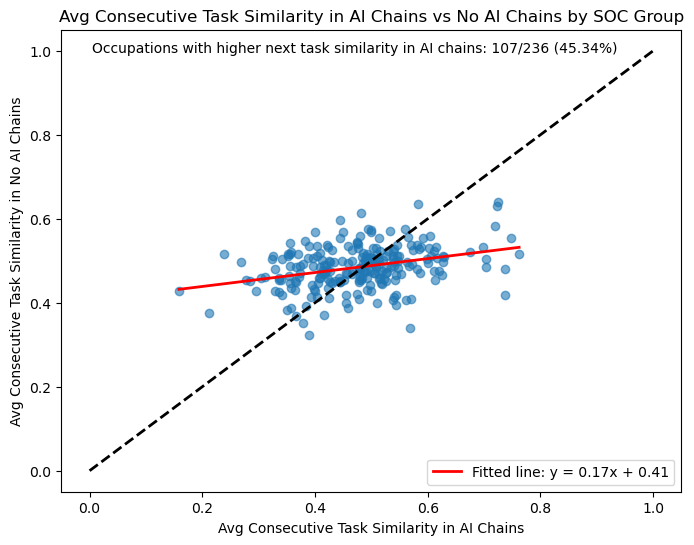

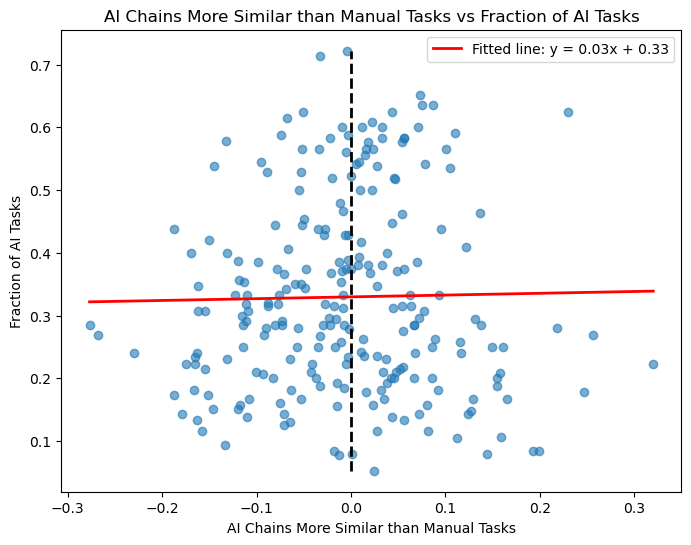

In [49]:
# Merge AI chain similarity and no AI chain similarity
chain_comparison_df = ai_chain_similarity[['O*NET-SOC Code', 'Occupation Title', 'avg_task_similarity_next_in_ai_chain']].merge(no_ai_chains_similarity, on=['O*NET-SOC Code', 'Occupation Title'], how='inner')
chain_comparison_df['ai_chains_more_similar'] = chain_comparison_df['avg_task_similarity_next_in_ai_chain'] - chain_comparison_df['avg_task_similarity_next_in_no_ai_chain']
chain_comparison_df = chain_comparison_df.sort_values(by='ai_chains_more_similar', ascending=False).reset_index(drop=True)
display(chain_comparison_df)

# Merge with occupation analysis data to get additional info
chain_comparison_df = chain_comparison_df.merge(occupation_analysis, on=['O*NET-SOC Code', 'Occupation Title'], how='left')
display(chain_comparison_df)

# Count how many occupations have higher similarity in AI chains
higher_in_ai_chains = (chain_comparison_df['ai_chains_more_similar'] > 0).sum()
total_occupations = len(chain_comparison_df)
print(f"Number of occupations with higher avg task similarity to next in AI chains: {higher_in_ai_chains} out of {total_occupations} ({(higher_in_ai_chains/total_occupations)*100:.2f}%)")


# Scatter plot of avg_task_similarity_next_in_ai_chain vs avg_task_similarity_next_in_no_ai_chain
x = chain_comparison_df['avg_task_similarity_next_in_ai_chain']
y = chain_comparison_df['avg_task_similarity_next_in_no_ai_chain']

# Fit a simple linear regression (1st-degree polynomial)
slope, intercept = np.polyfit(x, y, 1)
line_x = np.linspace(x.min(), x.max(), 100)
line_y = slope * line_x + intercept

plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.6)
plt.plot(line_x, line_y, color='red', linewidth=2, label=f'Fitted line: y = {slope:.2f}x + {intercept:.2f}')
plt.plot([0, 1], [0, 1], color='black', linestyle='--', linewidth=2)  # diagonal line
plt.title('Avg Consecutive Task Similarity in AI Chains vs No AI Chains by SOC Group')
plt.xlabel('Avg Consecutive Task Similarity in AI Chains')
plt.ylabel('Avg Consecutive Task Similarity in No AI Chains')
plt.text(0.05, 0.95, f'Occupations with higher next task similarity in AI chains: {higher_in_ai_chains}/{total_occupations} ({(higher_in_ai_chains/total_occupations)*100:.2f}%)', transform=plt.gca().transAxes)
plt.legend()
plt.savefig(f'{output_plot_path}/task_similarity_next_AI_vs_NonAI_chains.png')
plt.show()



# Scatter plot of ai_chains_more_similar vs ai_fraction
x = chain_comparison_df['ai_chains_more_similar']
y = chain_comparison_df['ai_fraction']

# Fit a simple linear regression (1st-degree polynomial)
slope, intercept = np.polyfit(x, y, 1)
line_x = np.linspace(x.min(), x.max(), 100)
line_y = slope * line_x + intercept

# Scatter + fitted line
plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.6)
plt.plot(line_x, line_y, color='red', linewidth=2, label=f'Fitted line: y = {slope:.2f}x + {intercept:.2f}')
plt.vlines(0, color='black', linestyle='--', linewidth=2, ymin=y.min(), ymax=y.max())
plt.title('AI Chains More Similar than Manual Tasks vs Fraction of AI Tasks')
plt.xlabel('AI Chains More Similar than Manual Tasks')
plt.ylabel('Fraction of AI Tasks')
plt.legend()
plt.savefig(f'{output_plot_path}/aiChainsMoreSimilar_vs_aiFraction.png')
plt.show()

,Minor_Group_Code,Minor_Group_Title,ai_chains_more_similar
27,29-9000,Other Healthcare Practitioners and Technical O...,0.25
44,51-8000,Plant and System Operators,0.24
43,49-2000,"Electrical and Electronic Equipment Mechanics,...",0.14
31,35-3000,Food and Beverage Serving Workers,0.13
25,29-1000,Healthcare Diagnosing or Treating Practitioners,0.09
45,51-9000,Other Production Occupations,0.08
30,35-1000,Supervisors of Food Preparation and Serving Wo...,0.07
9,17-3000,"Drafters, Engineering Technicians, and Mapping...",0.05
2,11-9000,Other Management Occupations,0.05
12,19-3000,Social Scientists and Related Workers,0.05


Number of occupations with higher avg task similarity to next in AI chains: 23 out of 46 (50.00%)


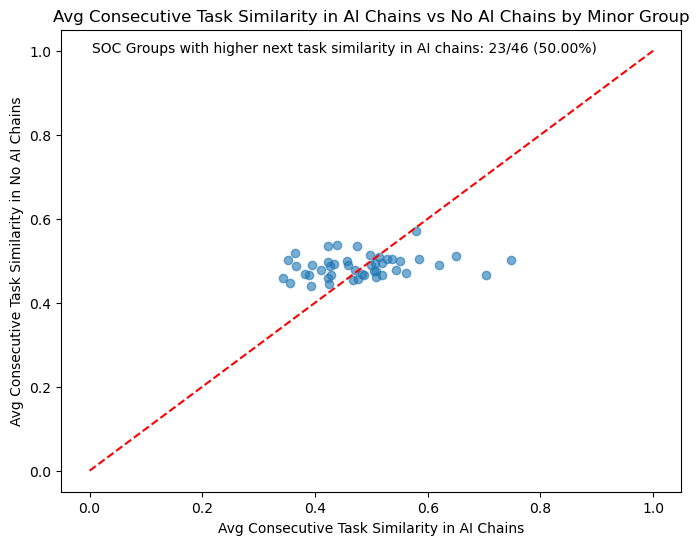

In [27]:
# Check if task_similarity_next is different across different SOC_group_code and SOC_group_title
SOC_group_code =  'Minor_Group_Code' # 'Detailed_Occupation_Code'
SOC_group_title =  'Minor_Group_Title' # 'Detailed_Occupation_Title'
SOC_group_plot_text = 'Minor Group' # 'Detailed Occupation Group'


# Merge SOC group codes and titles into ai_chains_df and no_ai_chains_df
group_similarity_chains = ai_chains_df.groupby([SOC_group_code, SOC_group_title]).agg(
    avg_task_similarity_next=('task_similarity_next', 'mean'),
    task_count=('task_similarity_next', 'count')
).reset_index()

group_similarity_no_chains = no_ai_chains_df.groupby([SOC_group_code, SOC_group_title]).agg(
    avg_task_similarity_next=('task_similarity_next', 'mean'),
    task_count=('task_similarity_next', 'count')
).reset_index()


# Merge ai_chain_similarity and no_ai_chains_similarity
comparison_df = group_similarity_chains.merge(group_similarity_no_chains, on=[SOC_group_code, SOC_group_title], how='inner', suffixes=('_ai_chains', '_no_ai_chains'))
comparison_df['ai_chains_more_similar'] = comparison_df['avg_task_similarity_next_ai_chains'] - comparison_df['avg_task_similarity_next_no_ai_chains']
display(comparison_df[[SOC_group_code, SOC_group_title, 'ai_chains_more_similar']].sort_values(by='ai_chains_more_similar', ascending=False))


# Calculate number and percentage of occupations where avg_task_similarity_next is higher in AI chains
higher_in_ai_chains = (comparison_df['ai_chains_more_similar'] > 0).sum()
total_occupations = len(comparison_df)
print(f"Number of occupations with higher avg task similarity to next in AI chains: {higher_in_ai_chains} out of {total_occupations} ({(higher_in_ai_chains/total_occupations)*100:.2f}%)")


# Scatter plot comparing avg_task_similarity_next in ai chains vs no ai chains
plt.figure(figsize=(8, 6))
plt.scatter(comparison_df['avg_task_similarity_next_ai_chains'], comparison_df['avg_task_similarity_next_no_ai_chains'], alpha=0.6)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title(f'Avg Consecutive Task Similarity in AI Chains vs No AI Chains by {SOC_group_plot_text}')
plt.xlabel('Avg Consecutive Task Similarity in AI Chains')
plt.ylabel('Avg Consecutive Task Similarity in No AI Chains')
plt.text(0.05, 0.95, f'SOC Groups with higher next task similarity in AI chains: {higher_in_ai_chains}/{total_occupations} ({(higher_in_ai_chains/total_occupations)*100:.2f}%)', transform=plt.gca().transAxes)
plt.savefig(f'{output_plot_path}/taskSimilarity_next_AIchains_vs_noAIchains_bySOCGroup.png')
plt.show()